# 🧠 M5 Forecasting – Análise Exploratória de Dados (EDA) – Versão Revisada

Este notebook é a versão revisada do meu EDA para o desafio **M5 Forecasting – Accuracy**, 
disponível no Kaggle. O objetivo do projeto é analisar e preparar os dados para futuros 
modelos de previsão de demanda (forecasting) de produtos vendidos pela Walmart.

---

## 🎯 Contexto de Negócio

A Walmart, maior varejista do mundo, precisa prever **vendas diárias** de milhares de 
produtos em diversas lojas e estados dos EUA. Previsões consistentes ajudam a:

- reduzir rupturas de estoque (evitar prateleiras vazias),
- diminuir estoque excessivo (capital parado),
- melhorar planejamento logístico e financeiro,
- dar suporte a decisões comerciais (promoções, compras, etc.).

A competição **M5 Forecasting – Accuracy** faz parte das competições da série “M” de forecasting 
e foi organizada para comparar diferentes abordagens de previsão usando dados reais da Walmart. :contentReference[oaicite:0]{index=0}

---

## 📦 Fonte dos Dados (Kaggle)

Os dados foram obtidos a partir da competição:

🔗 **M5 Forecasting – Accuracy (Kaggle)**  
https://www.kaggle.com/competitions/m5-forecasting-accuracy :contentReference[oaicite:1]{index=1}

O conjunto de dados contém:

- **sales_train_validation.csv** – histórico de vendas diárias (várias séries temporais, uma por produto/loja);
- **calendar.csv** – informações de calendário (datas, feriados, eventos, etc.);
- **sell_prices.csv** – histórico de preços por loja/produto/semana.

---

## 🗂 Objetivo deste Notebook

O foco deste notebook é:

1. **Carregar os dados brutos** (M5) de forma organizada;
2. **Reduzir o uso de memória** com técnicas como *downcasting* de tipos numéricos;
3. **Transformar os dados de vendas de formato wide para long** (melt);
4. **Combinar as tabelas de vendas, calendário e preços**;
5. **Criar features temporais básicas** (dia da semana, semana, mês, ano);
6. **Salvar um dataset intermediário** em formato Parquet para uso posterior em modelagem;
7. **Visualizar um exemplo de série temporal** para um produto específico.

Por questões de memória RAM, em alguns testes restringimos a análise a **apenas um `dept_id`** 
(departamento), o que diminui bastante a quantidade de linhas processadas.

---

## 🧱 Estrutura do Notebook

1. Configuração inicial e imports  
2. Função de otimização de memória (`downcast`)  
3. Carregamento dos dados do M5  
4. Preparação: filtro de departamento, melt e merges  
5. Criação de features temporais  
6. Salvando o dataset intermediário  
7. Visualização de uma série temporal de exemplo

Este notebook foi escrito com foco em **legibilidade e clareza**, pensando em portfólio 
(GitHub / Kaggle / currículo).

In [4]:
from pathlib import Path

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Deixar os gráficos com layout mais agradável
plt.style.use("seaborn-v0_8-whitegrid")

# === Caminhos do projeto ===
# BASE: pasta raiz (um nível acima do notebook)
BASE = Path("..").resolve()

DATA = BASE / "data"
RAW = Path(r"C:\Users\guife\Downloads\m5_project\data\external")     # onde ficam os arquivos brutos do Kaggle
INTERIM = DATA / "interim"   # onde vamos salvar os dados intermediários
PROCESSED = DATA / "processed"

# Garante que as pastas existam (interim e processed)
INTERIM.mkdir(parents=True, exist_ok=True)
PROCESSED.mkdir(parents=True, exist_ok=True)

# === Caminho da pasta src com funções auxiliares ===
SRC = BASE / "src"
sys.path.append(str(SRC))

print("BASE:", BASE)
print("DATA:", DATA)
print("SRC adicionado ao sys.path:", SRC)

# Importa funções utilitárias criadas para o projeto M5
from data_prep import load_m5, melt_sales, merge_prices

BASE: C:\Users\guife
DATA: C:\Users\guife\data
SRC adicionado ao sys.path: C:\Users\guife\src


In [5]:
def downcast(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reduz o uso de memória de um DataFrame, convertendo colunas numéricas
    para tipos menores (int32, float32) e colunas de texto para 'category'
    quando possível.
    """
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i, t in enumerate(types):
        col = cols[i]

        # Inteiros: tenta converter para int32 se o range permitir
        if "int" in str(t):
            min_val = df[col].min()
            max_val = df[col].max()
            if min_val > np.iinfo(np.int32).min and max_val < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)

        # Floats: tenta converter para float32 se o range permitir
        elif "float" in str(t):
            min_val = df[col].min()
            max_val = df[col].max()
            if min_val > np.finfo(np.float32).min and max_val < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

        # Objetos (texto): converte para category, exceto a coluna 'date'
        elif "object" in str(t):
            if col != "date":
                df[col] = df[col].astype("category")

    return df

In [6]:
# Carrega os três principais dataframes do M5
dfs = load_m5(RAW)

calendar = dfs["calendar"]
sales = dfs["sales_train_validation"]
prices = dfs["sell_prices"]

print("calendar shape antes do downcast:", calendar.shape)
print("sales shape antes do downcast:", sales.shape)
print("prices shape antes do downcast:", prices.shape)

# Otimiza memória com downcast
calendar = downcast(calendar)
sales = downcast(sales)
prices = downcast(prices)

print("\nTipos de dados após downcast (calendar):")
print(calendar.dtypes.head())

calendar shape antes do downcast: (1969, 14)
sales shape antes do downcast: (30490, 1919)
prices shape antes do downcast: (6841121, 4)

Tipos de dados após downcast (calendar):
date          object
wm_yr_wk       int32
weekday     category
wday           int32
month          int32
dtype: object


In [22]:
# --- Ajusta o calendário e seleciona colunas relevantes ---
calendar["wm_yr_wk"] = calendar["wm_yr_wk"].astype("int32")

cal_week = calendar[
    ["d", "wm_yr_wk", "date", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]
].copy()

print("Colunas do calendar usadas no merge:", cal_week.columns.tolist())
print("Tamanho de cal_week:", cal_week.shape)

# --- Reduz o dataset para 1 dept_id (para testes e menor uso de memória) ---
dept_ref = sales["dept_id"].iloc[0]
sales_sub = sales[sales["dept_id"] == dept_ref].copy()

print(f"Departamento selecionado: {dept_ref}")
print("Dimensões de sales_sub:", sales_sub.shape)

# --- Transformação de wide para long (melt) ---
df_long = melt_sales(sales_sub)
print("Dimensões de df_long (após melt):", df_long.shape)
print(df_long.head())

# --- Merge com o calendário ---
merged = df_long.merge(cal_week, on="d", how="left")

# Garante que a coluna date está em datetime
merged["date"] = pd.to_datetime(merged["date"], errors="coerce")

print("Colunas após merge com calendar:", merged.columns.tolist())
print("Shape após merge com calendar:", merged.shape)

# ---Merge com preços ---
prices["wm_yr_wk"] = prices["wm_yr_wk"].astype("int32")

merged_prices = merge_prices(merged, prices)
print("Shape após merge com prices:", merged_prices.shape)

merged_prices.head()

Colunas do calendar usadas no merge: ['d', 'wm_yr_wk', 'date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
Tamanho de cal_week: (1969, 7)
Departamento selecionado: HOBBIES_1
Dimensões de sales_sub: (4160, 1919)
Dimensões de df_long (após melt): (7958080, 8)
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales  
0       CA  d_1      0  
1       CA  d_1      0  
2       CA  d_1      0  
3       CA  d_1      0  
4       CA  d_1      0  
Colunas após merge com calendar: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,date,event_name_1,event_type_1,event_name_2,event_type_2,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN


In [8]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adiciona features temporais básicas a partir da coluna 'date':
    - dow   (day of week)
    - week  (semana ISO)
    - month (mês)
    - year  (ano)
    """
    out = df.copy()

    if "date" not in out.columns:
        raise ValueError("Coluna 'date' não encontrada. Faça o merge com o calendário antes.")

    # Garante que 'date' é datetime
    if not pd.api.types.is_datetime64_any_dtype(out["date"]):
        out["date"] = pd.to_datetime(out["date"], errors="coerce")

    out["dow"] = out["date"].dt.dayofweek
    out["week"] = out["date"].dt.isocalendar().week.astype(int)
    out["month"] = out["date"].dt.month
    out["year"] = out["date"].dt.year

    return out

In [9]:
feat = add_time_features(merged_prices)

print("Shape de feat (com features temporais):", feat.shape)
feat.head()

Shape de feat (com features temporais): (7958080, 19)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,date,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,dow,week,month,year
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN,5,4,1,2011
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN,5,4,1,2011
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN,5,4,1,2011
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN,5,4,1,2011
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,2011-01-29,NaN,NaN,NaN,NaN,NaN,5,4,1,2011


In [10]:
output_path = INTERIM / "m5_long_with_features_rev.parquet"

feat.to_parquet(output_path, index=False)

print("Arquivo salvo em:", output_path)
feat.shape

Arquivo salvo em: C:\Users\guife\data\interim\m5_long_with_features_rev.parquet


(7958080, 19)

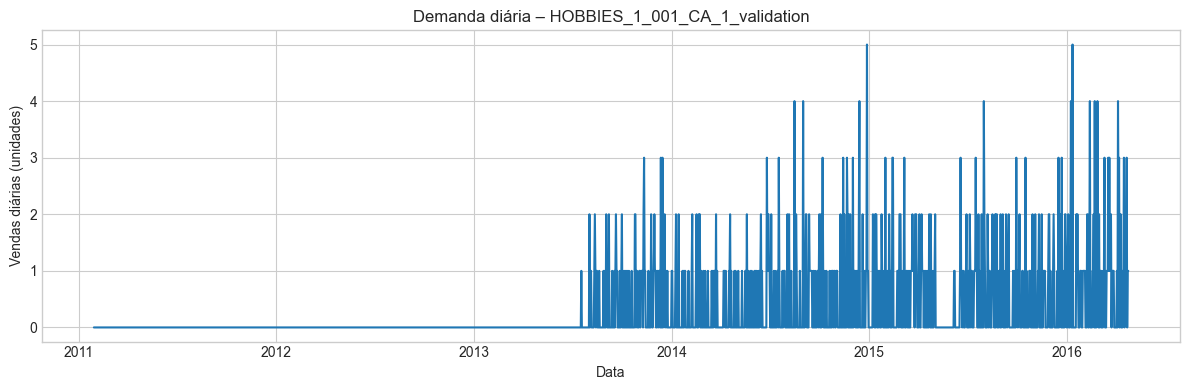

In [11]:
# Seleciona um id qualquer para exemplo
sample_id = feat["id"].iloc[0]

example = (
    feat[feat["id"] == sample_id]
    .sort_values("date")
)

plt.figure(figsize=(12, 4))
plt.plot(example["date"], example["sales"])
plt.title(f"Demanda diária – {sample_id}")
plt.xlabel("Data")
plt.ylabel("Vendas diárias (unidades)")
plt.tight_layout()
plt.show()

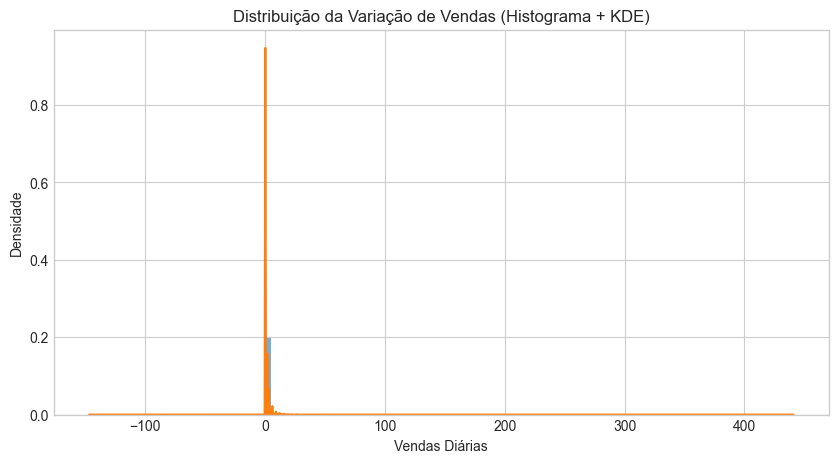

In [12]:
plt.figure(figsize=(10,5))
plt.hist(feat["sales"], bins=60, density=True, alpha=0.6)
feat["sales"].plot(kind='kde')

plt.title("Distribuição da Variação de Vendas (Histograma + KDE)")
plt.xlabel("Vendas Diárias")
plt.ylabel("Densidade")
plt.show()

É comum observar muitos valores baixos (produtos vendem pouco por dia).

A cauda direita tende a ser longa → poucos produtos vendem muito.

Isso confirma que precisamos de métodos robustos para forecasting, pois há forte assimetria.

<Figure size 1000x500 with 0 Axes>

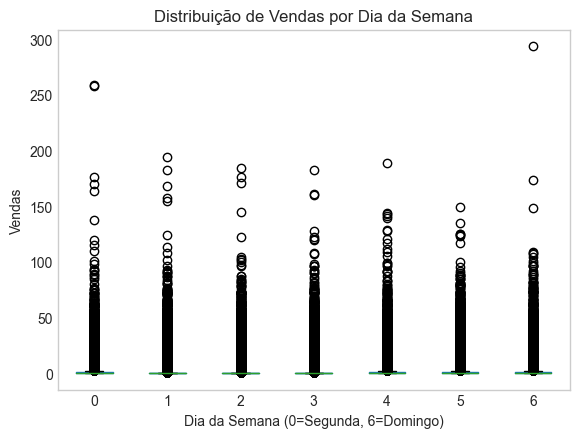

In [13]:
plt.figure(figsize=(10,5))
feat.boxplot(column="sales", by="dow", grid=False)
plt.title("Distribuição de Vendas por Dia da Semana")
plt.suptitle("")
plt.xlabel("Dia da Semana (0=Segunda, 6=Domingo)")
plt.ylabel("Vendas")
plt.show()

Normalmente, o varejo vende mais sexta e sábado.

Segunda tende a ser mais fraca.

Se os quartis sobem no fim de semana → sazonalidade semanal confirmada.

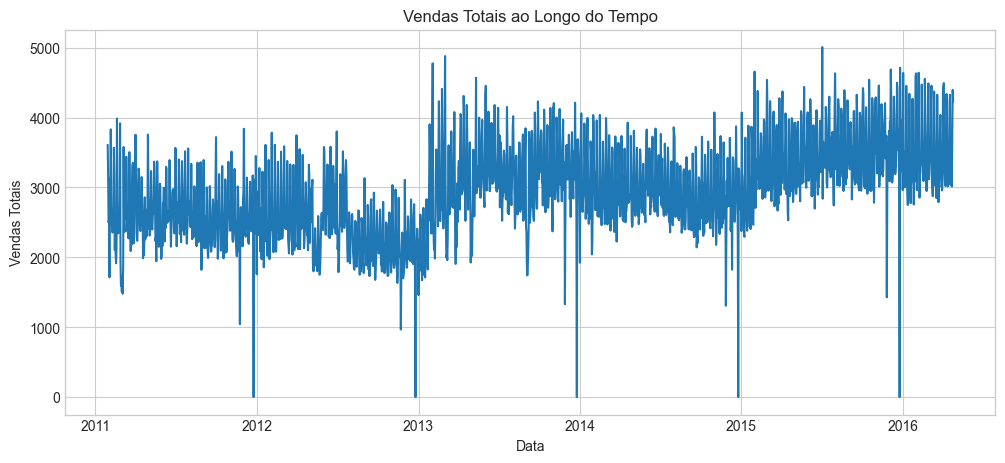

In [14]:
tmp = feat.groupby("date")["sales"].sum()

plt.figure(figsize=(12,5))
plt.plot(tmp.index, tmp.values)
plt.title("Vendas Totais ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Vendas Totais")
plt.show()

Possível ver períodos de queda ou alta.

Datas de promoções e feriados podem gerar picos.

Se o gráfico apresenta "marolas", isso indica sazonalidade clara.

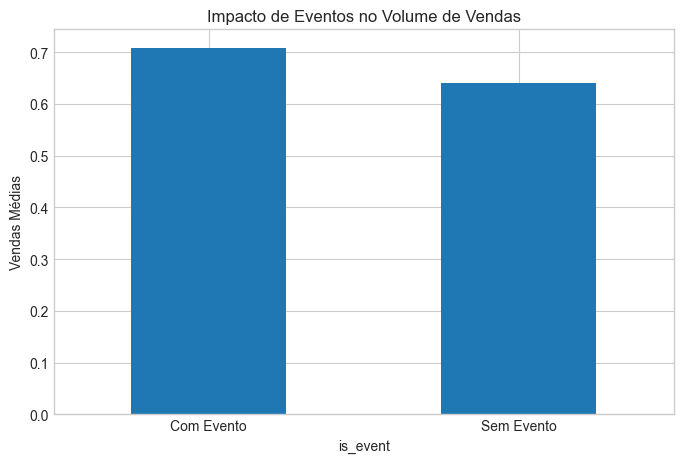

In [17]:
feat["is_event"] = feat["event_name_1"].notna().astype(int)

plt.figure(figsize=(8,5))
feat.groupby("is_event")["sales"].mean().plot(kind="bar")

plt.xticks([0,1], ["Com Evento", "Sem Evento"], rotation=0)
plt.ylabel("Vendas Médias")
plt.title("Impacto de Eventos no Volume de Vendas")
plt.show()

Geralmente as vendas sobem em dias com evento.

Se o aumento for forte → eventos influenciam poderosamente a demanda.

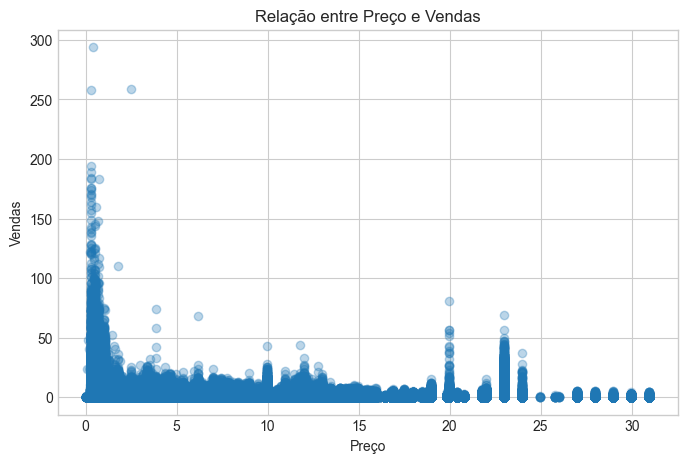

In [18]:
plt.figure(figsize=(8,5))
plt.scatter(feat["sell_price"], feat["sales"], alpha=0.3)

plt.xlabel("Preço")
plt.ylabel("Vendas")
plt.title("Relação entre Preço e Vendas")
plt.show()

Tendência típica: quanto maior o preço → menores as vendas.

Se a nuvem de pontos mostrar queda → comportamento clássico de elasticidade.

Se não: produto é essencial ou preço pouco variável.

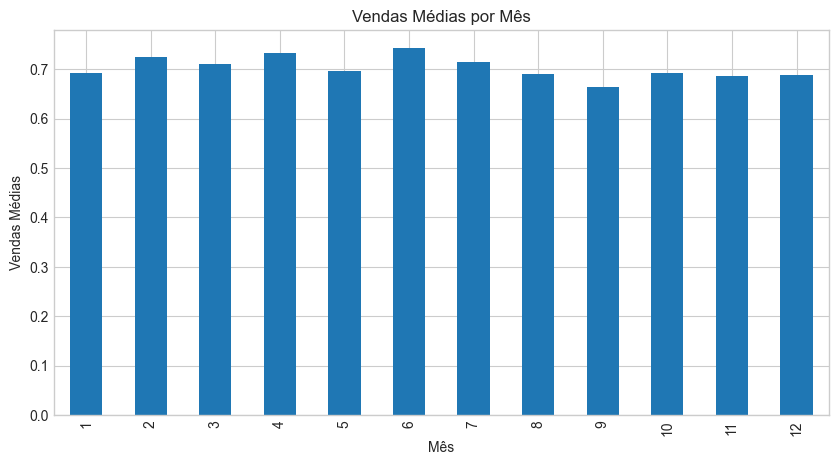

In [19]:
plt.figure(figsize=(10,5))
feat.groupby("month")["sales"].mean().plot(kind="bar")

plt.xlabel("Mês")
plt.ylabel("Vendas Médias")
plt.title("Vendas Médias por Mês")
plt.show()

Picos no fim do ano → sazonalidade anual.

Quedas no verão/início do ano → padrão comum no varejo.

<Figure size 1200x500 with 0 Axes>

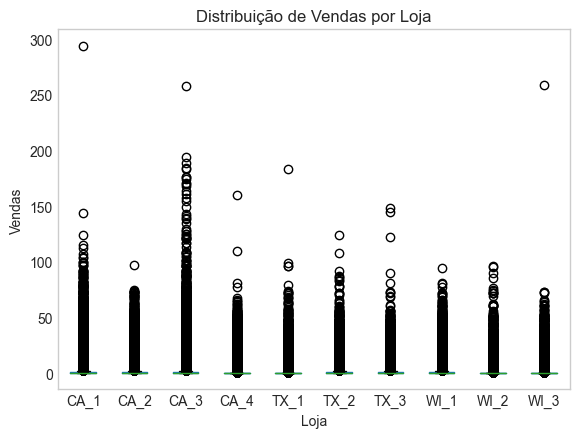

In [20]:
plt.figure(figsize=(12,5))
feat.boxplot(column="sales", by="store_id", grid=False)
plt.title("Distribuição de Vendas por Loja")
plt.suptitle("")
plt.xlabel("Loja")
plt.ylabel("Vendas")
plt.show()

Identifica lojas mais fortes e mais fracas.

Outliers podem mostrar promoções regionais ou rupturas.

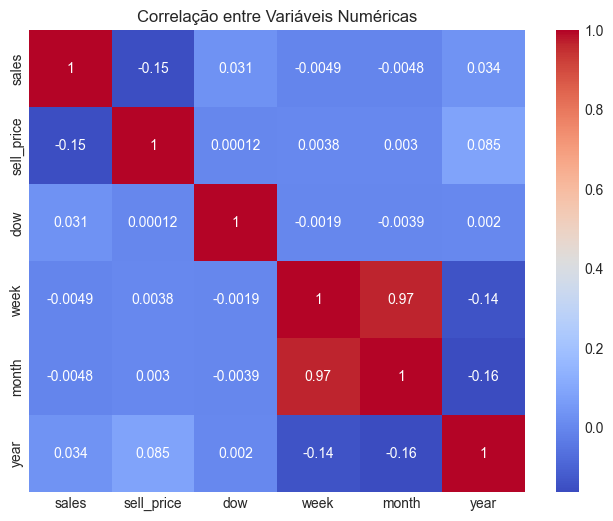

In [21]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(feat[["sales","sell_price","dow","week","month","year"]].corr(),
            annot=True, cmap="coolwarm")

plt.title("Correlação entre Variáveis Numéricas")
plt.show()

sales vs sell_price → tende a ser negativa.

sales vs dow → fortes padrões semanais.

sales vs month → sazonalidade anual.

## CONCLUSÃO GERAL

Após realizar a análise exploratória visual com os gráficos acima, observamos diversos padrões importantes no comportamento da demanda do M5 Forecasting:

🔹1. Distribuições Assimétricas

(Histograma + KDE)**
As vendas diárias são altamente assimétricas:

grande parte dos produtos vendem pouco,

poucos vendem muito (cauda longa).
Isso implica em modelos que precisam lidar com alta variabilidade.

🔹2. Sazonalidade Semanal

(Boxplot por dia da semana)**
Há um padrão claro em que o fim de semana apresenta maior volume de vendas.
Isso sugere que modelos devem incluir features de calendário (day-of-week, weekend indicator).

🔹3. Tendências de Longo Prazo

(Gráfico de linha)**
O volume total apresenta flutuações indicativas de sazonalidade e possíveis choques de demanda.
Modelos de forecasting devem considerar tendência + sazonalidade.

🔹4. Impacto de Eventos

Dias com eventos/feriados apresentam vendas maiores — eventos são variáveis-chave.

🔹5. Relação Preço × Demanda

Existe relação negativa entre preço e vendas, confirmando elasticidade de demanda.

🔹6. Sazonalidade Mensal

Certos meses apresentam picos (principalmente final de ano), reforçando sazonalidade anual.

🔹7. Diferença entre Lojas

As lojas têm comportamentos distintos — modelos podem exigir efeitos por loja (store-level).

🔹8. Correlação entre Variáveis

A matriz de correlação mostra:

forte dependência temporal;

preço é variável crítica;

eventos e calendário influenciam fortemente as vendas.

A demanda do varejo (M5) é fortemente dependente de preço, sazonalidade semanal, sazonalidade anual e eventos. Os dados apresentam alta assimetria e grande variabilidade entre lojas. Essas conclusões orientam a construção de modelos robustos que incluam múltiplas camadas de sazonalidade, variáveis de calendário e ajustes de elasticidade de preço.